# Sistema de Unidades

Establecemos un Sistema de Unidades

In [1]:
# Unidades Base
m = 1
kg = 1
s = 1
# Otras Unidades
cm = 0.01*m
N = kg*m/s**2
kN = 1000*N
kgf = 9.80665*N
tonf = 1000*kgf
Pa = N/m**2
# Constantes Físicas
g = 9.80665*m/s**2

Importamos las librerías a utilizar

# Propiedades del material y de secciones

Definimos la propiedad de los materiales

In [2]:
fc = 210*kg/cm**2
E = 151*fc**0.5*kgf/cm**2
G = 0.5*E/(1+0.2)
# Viga
b,h = 30*cm, 60*cm
Av = b*h
Izv = b*h**3/12
Iyv = b**3*h/12
aa, bb = max(b,h),min(b,h)
β= 1/3-0.21*bb/aa*(1-(bb/aa)**4/12)
Jxxv = β*bb**3*aa
# Columna
a = 60*cm
Ac = a**2
Izc = a**4/12
Iyc = a**4/12
β= 1/3-0.21*1.*(1-(1.)**4/12)
Jxxc = β*a**4
# Densidad del concreto
ρ = 2400*kg/m**3

# Librerías

Instalamos la librería OpenSeesPy

In [3]:
pip install openseespy

In [4]:
pip install matplotlib==3.3.3

In [5]:
import matplotlib
print(matplotlib.__version__)

3.3.3


In [6]:
import numpy as np
import pandas as pd
from openseespy.opensees import *
import openseespy.postprocessing.ops_vis as opsv
import matplotlib.pyplot as plt

# Creación del Modelo

Definimos las dimensiones y grados de libertad por nodo.

In [7]:
#@title
def GeoModel(dx, dy, h, nx, ny, nz):
    from numpy import zeros
    Lx, Ly, Lz = dx*nx, dy*ny, h*nz
    NN = (nx+1)*(ny+1)*(nz+1)
    Nodes = zeros((NN,5))
    # Creando los nodos y asignando coordenadas
    c = 0
    for i in range(nz+1):
        for j in range(ny+1):
            for k in range(nx+1):
                if k == nx and j != ny and j!= 0:
                    Nodes[c] = [c,k*dx,j*dy,i*h,0.50]
                elif k != nx and j == ny  and k!= 0:
                    Nodes[c] = [c,k*dx,j*dy,i*h,0.50]
                elif k == 0 and j != ny and j!= 0:
                    Nodes[c] = [c,k*dx,j*dy,i*h,0.50]
                elif k != nx and j == 0  and k!= 0:
                    Nodes[c] = [c,k*dx,j*dy,i*h,0.50]
                elif k == nx and j == ny:
                    Nodes[c] = [c,k*dx,j*dy,i*h,0.25]
                elif k == 0 and j == 0:
                    Nodes[c] = [c,k*dx,j*dy,i*h,0.25]
                elif k == nx and j == 0:
                    Nodes[c] = [c,k*dx,j*dy,i*h,0.25]
                elif k == 0 and j == ny:
                    Nodes[c] = [c,k*dx,j*dy,i*h,0.25]
                else:
                    Nodes[c] = [c,k*dx,j*dy,i*h,1.00]
                c = c + 1
    Nodes[:(nx+1)*(ny+1),4]=0
    # print(Nodes)

    NE = (nx*(ny+1)+ny*(nx+1)+(nx+1)*(ny+1))*nz
    Elems = zeros((NE,4))
    # Creando las conexiones de los elementos verticales
    c = 0
    for i in range(nz):
        for j in range(ny+1):
            for k in range(nx+1):
                Elems[c] = [c,c,c+(nx+1)*(ny+1),1]
                c = c + 1
    # Creando las conexiones de los elementos horizontales
    m = (nx+1)*(ny+1)
    for i in range(nz):
        for j in range(ny+1):
            for k in range(nx):
                Elems[c] = [c,m,m+1,2]
                m = m + 1
                c = c + 1
            m = m + 1
    # Creando las conexiones de los elementos horizontales
    n = 0 
    for i in range(nz):
        n = n + (nx+1)*(ny+1)
        for j in range(nx+1):
            for k in range(ny):
                Elems[c] = [c,j+k*(nx+1)+n,j+nx+1+k*(nx+1)+n,2]
                c = c + 1
    # Creando centro de diafragmas
    Diap = zeros((nz,4))
    for i in range(nz):
        Diap[i] = [i+1000,Lx/2.0,Ly/2.0,h*(i+1)]
    #
    return Nodes, Elems, Diap

In [8]:
wipe()
model('basic', '-ndm', 3, '-ndf', 6)

# Generamos la malla
RigidDiaphragm = 'ON'
dx, dy, dz = 4, 4, 3
nx, ny, nz = 5, 4, 8
# Nodos del Modelo
Nodes, Elems, Diap = GeoModel(dx,dy,dz,nx,ny,nz)
print(Diap)

[[1000.   10.    8.    3.]
 [1001.   10.    8.    6.]
 [1002.   10.    8.    9.]
 [1003.   10.    8.   12.]
 [1004.   10.    8.   15.]
 [1005.   10.    8.   18.]
 [1006.   10.    8.   21.]
 [1007.   10.    8.   24.]]


Creamos nodos del modelo

In [9]:
# Creamos los nodos
for Ni in Nodes:
  node(int(Ni[0]), *Ni[1:4])

# Definimos diafragmas rígidos
if RigidDiaphragm == 'ON':
  dirDia = 3 # perpendicular al plano del diafragma
  for Nd in Diap:
    node(int(Nd[0]), *Nd[1:4])
    fix(int(Nd[0]),*[0,0,1,1,1,0])
    NodesDi = []
    for Ni in Nodes:
      if Ni[3]==Nd[3]:
        NodesDi.append(int(Ni[0]))
    rigidDiaphragm(dirDia,int(Nd[0]),*NodesDi)

Asignamos restricciones en los nodos de la base

In [10]:
# Restricciones
fixZ(0.0, *[1,1,1,1,1,1], '-tol', 1e-6)

Ejes Locales en OpenSees:
1. Se define el eje Local X en la dirección del elemento y en el orden de los nodos que lo definen.
2. Se define un vector vxz en la transformación geométrica. Este vector junto con el eje local X forman un plano XZ. 
3. En este plano XZ, se define el eje local Z perpendicular al eje local X.
4. Según la regla de la mano derecha se define el eje local Y.

Establecemos una transformación geométrica

In [11]:
geomTransf('PDelta', 1, *[1, 0, 0])
geomTransf('Linear', 2, *[1,-1, 0])

Definimos los elementos con sus propiedades respectivas

In [12]:
# Creamos los elementos
for Ele in Elems:
  if int(Ele[3]) == 1:# 1 Columna
    element('elasticBeamColumn', int(Ele[0]), int(Ele[1]), int(Ele[2]), Ac, E, G, Jxxc, Iyc, Izc, int(Ele[3]),'-mass', ρ*Ac)
  else: # 2 Viga
    element('elasticBeamColumn', int(Ele[0]), int(Ele[1]), int(Ele[2]), Av, E, G, Jxxv, Iyv, Izv, int(Ele[3]),'-mass', ρ*Av)#*(dx-a)/dx)

# Ploteo del Modelo

Plotemos el modelo creado

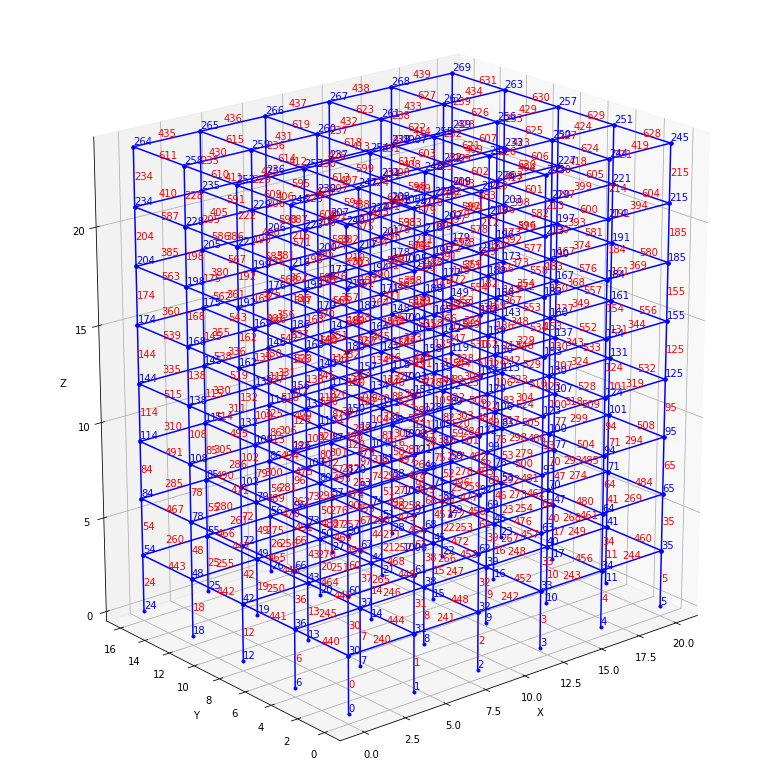

In [13]:
opsv.plot_model(fig_wi_he=(30., 40.),az_el=(-130,20))

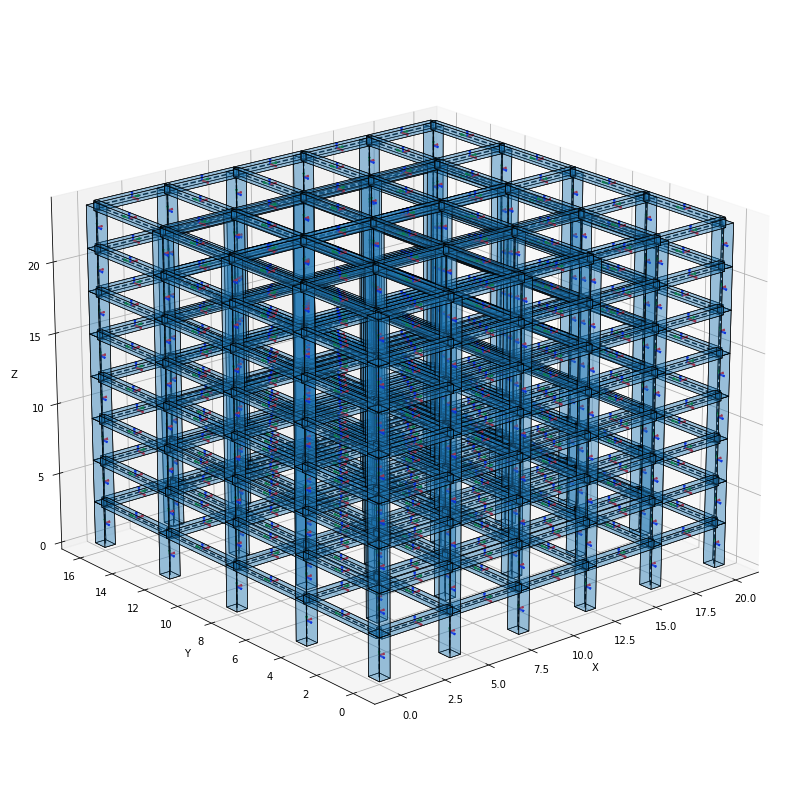

In [14]:
ele_shapes = {}
for i in range(len(Elems)):
    if int(Elems[i,3])==1: # Column
        ele_shapes[i] = ['rect', [a, a]]
    elif int(Elems[i,3])==2: # Beam
        ele_shapes[i] = ['rect', [b, h]]
    else:
      print('Error. No es ni elemento viga ni columna.')
opsv.plot_extruded_shapes_3d(ele_shapes, fig_wi_he=(40.0, 32.0), 
                        az_el=(-130,20),fig_lbrt = (0, 0, 1, 1))
# plt.axis([0,nx*dx,0,ny*dy])

# Asignación de Masas y Modos de Vibración

In [15]:
# Aplicando Cargas vivas y muertas
wLive = 250*kg/m**2
wLosa = 300*kg/m**2
wAcab = 100*kg/m**2
wTabi = 150*kg/m**2
wTotal = 1.0*(wLosa+wAcab+wTabi)+0.25*wLive
print(wTotal)
#
Carga = wTotal*dx*dy*m**2
for Ni in Nodes:
    mass(int(Ni[0]),Ni[4]*Carga,Ni[4]*Carga,0.0)

612.5


No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>

T[1]: 0.72187
T[2]: 0.70772
T[3]: 0.63466
T[4]: 0.23109
T[5]: 0.22713
T[6]: 0.20445
T[7]: 0.12877
T[8]: 0.12717
T[9]: 0.11550
T[10]: 0.08541
T[11]: 0.08459
T[12]: 0.07700


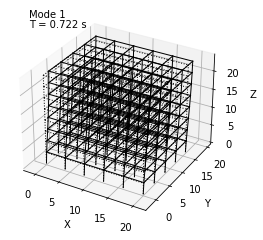

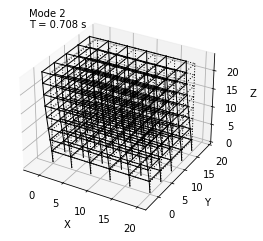

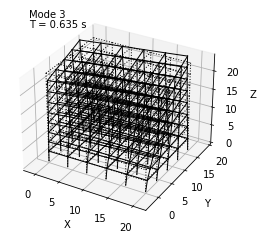

In [16]:
# Obtenemos los modos
Nmodes = 12

# ploteamos el modo 1
import openseespy.postprocessing.Get_Rendering as opsplt
opsplt.plot_modeshape(1, 2000)
plt.savefig('./modo_1.png',dpi=300)
opsplt.plot_modeshape(2, 2000)
opsplt.plot_modeshape(3, 2000)

vals = eigen(Nmodes)
Tmodes = np.zeros(len(vals))
for i in range(Nmodes):
    Tmodes[i] = 2*np.pi/vals[i]**0.5
    print("T[%i]: %.5f"%(i+1,Tmodes[i]))

Análisis para obtener la matriz de Masas

In [17]:
# Realizamos un análisis para obtener la matriz de Masas
wipeAnalysis()
system('FullGeneral')
numberer("Plain")
constraints('Transformation') 
algorithm('Linear')
analysis('Transient')
integrator('GimmeMCK',1.0,0.0,0.0)
analyze(1,0.0) 

# Obtenemos la matriz de Masas
N = systemSize()         # Número de Grados de Libertad
Mmatrix = printA('-ret')
Mmatrix = np.array(Mmatrix).reshape((N,N))
MF = Mmatrix[-3*nz:,-3*nz:]

WARNING analysis Transient - no Integrator specified, 
 TransientIntegrator default will be used
WARNING FullGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 1
WARNING Linear::solveCurrentStep() -the LinearSOE failed in solve()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0
OpenSees > analyze failed, returned: -3 error flag


# Análisis Estático en X

In [18]:
#@title
def espectro_E030(T,Z=0.45,U=1.5,S=1.0,Tp=0.4,Tl=2.5,R=1):
    from numpy import zeros
    n = len(T)
    E030 = zeros(n)
    for i in range(n):
        if T[i]>=0 and T[i]<0.2*Tp:
            E030[i]=2.5#1+7.5*T[i]/Tp
        elif T[i]>=0.2*Tp and T[i]<Tp:
            E030[i]=2.5
        elif T[i]>=Tp and T[i]<Tl:
            E030[i] = 2.5*(Tp/T[i])
        elif T[i]>=Tl:
            E030[i] = 2.5*(Tp*Tl/T[i]**2)
        else:
            print("El periodo no puede ser negativo!")
    return E030*Z*U*S/R

def get_static_loads(coef,p,h,T):
    from numpy import zeros
    n = len(h)
    V = coef*sum(p)
    F = zeros(n)
    #
    if T > 0.0 and T <= 0.5:
        k=1.0
    elif T>0.5:
        k = 0.75+0.5*T
    else:
        print('El periodo es negativo!')
    #
    div = 0.
    for i in range(n):
        div = div + p[i]*h[i]**k
    #
    for i in range(n):
        F[i] = p[i]*h[i]**k/div*V
    return F,k

In [19]:
np.set_printoptions(precision=3,linewidth=300,suppress=True)
H = np.arange(1,nz+1)*dz
P = sum(MF[0::3,0::3])*9.80665 # Peso por nivel
print(H,P)
Ro = 8.
E030 = espectro_E030(Tmodes,Z=0.45,U=1.0,S=1.0,Tp=0.4,Tl=2.5,R=Ro)
F, k = get_static_loads(E030[0],P,H,Tmodes[0])
CR = E030[0]/(0.45*1.*1.)
print('C/R=',CR)
print(E030[0],k)

[ 3  6  9 12 15 18 21 24] [3515017.173 3515017.173 3515017.173 3515017.173 3515017.173 3515017.173 3515017.173 3133734.621]
C/R= 0.1731610693655234
0.07792248121448553 1.1109356319466333


Aplicamos fuerzas nodales

In [20]:
# Aplicando fuerzas estáticas en X
timeSeries('Linear',1)
pattern('Plain',1,1)
Le = ny*dy*0.05
for i in range(nz):
    print(int(Diap[i][0]))
    load(int(Diap[i][0]),F[i],0.,0.,0.,0.,F[i]*Le)

1000
1001
1002
1003
1004
1005
1006
1007


Realizamos el análisis

In [21]:
wipeAnalysis()
constraints('Transformation')
numberer('Plain')
system('FullGeneral')
algorithm('Linear')
integrator('LoadControl',1)
analysis('Static')
analyze(1)

0

Calculando cortantes

In [22]:
VS = np.cumsum(F[::-1])[::-1]

Resultados del análisis estático

In [23]:
# Desplazamientos
df1 = pd.DataFrame(columns=['Nivel','Vx(kN)','UxMax(cm)','UyMax(cm)','DriftX(‰)','DriftY(‰)'])
tempX, tempY = 0., 0.
for i in range(nz):
    desX = nodeDisp(int(Diap[i][0]),1)
    desY = nodeDisp(int(Diap[i][0]),2)
    rotZ = nodeDisp(int(Diap[i][0]),6)
    desX = desX + abs(rotZ*ny*dy/2)
    desY = desY + abs(rotZ*nx*dx/2)
    desX, desY = desX*0.75*Ro, desY*0.75*Ro
    driftX = 1000.*(desX-tempX)/dz
    driftY = 1000.*(desY-tempY)/dz 
    tempX, tempY = desX, desY
    df1 = df1.append({'Nivel':i+1,'Vx(kN)':VS[i]/1000,'UxMax(cm)':desX*100,'UyMax(cm)':desY*100,
                    'DriftX(‰)':driftX,'DriftY(‰)':driftY}, ignore_index=True)
print('\nANÁLISIS ESTÁTICO EN X')
print(df1.round(4))


ANÁLISIS ESTÁTICO EN X
   Nivel     Vx(kN)  UxMax(cm)  UyMax(cm)  DriftX(‰)  DriftY(‰)
0    1.0  2161.4804     1.0596     0.0979     3.5320     0.3263
1    2.0  2110.2360     2.8042     0.2578     5.8152     0.5330
2    3.0  1999.5553     4.5935     0.4205     5.9644     0.5424
3    4.0  1825.8962     6.2627     0.5712     5.5640     0.5022
4    5.0  1586.8419     7.7306     0.7026     4.8931     0.4380
5    6.0  1280.5346     8.9318     0.8088     4.0039     0.3543
6    7.0   905.4557     9.8086     0.8848     2.9226     0.2533
7    8.0   460.3162    10.3387     0.9286     1.7671     0.1460


Se plotea la deformación obtenida

<IPython.core.display.Javascript object>

200

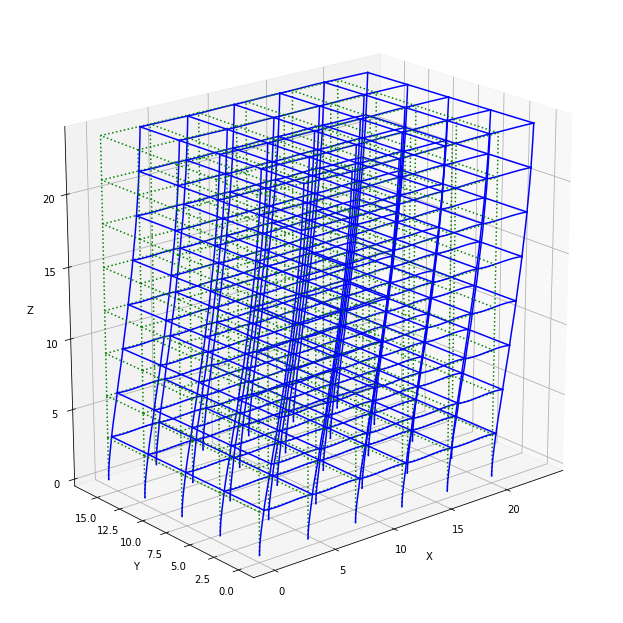

In [24]:
opsv.plot_defo(200,fig_wi_he=(30., 25.),az_el=(-130,20))


# Análisis Estático en Y

In [25]:
loadConst('-time', 0.0)
remove('timeSeries',1)
remove('loadPattern',1)
timeSeries('Linear',1)
pattern('Plain',1,1)
Le = nx*dx*0.05
for i in range(nz):
    print(int(Diap[i][0]))
    load(int(Diap[i][0]),0.,F[i],0.,0.,0.,F[i]*Le)

1000
1001
1002
1003
1004
1005
1006
1007


Realizamos el análisis

In [26]:
wipeAnalysis()
constraints('Transformation')
numberer('Plain')
system('FullGeneral')
algorithm('Linear')
integrator('LoadControl',1)
analysis('Static')
analyze(1)

0

Calculando cortantes

In [27]:
VS = np.cumsum(F[::-1])[::-1]

Resultados del análisis estático

In [28]:
# Desplazamientos
df2 = pd.DataFrame(columns=['Nivel','Vy(kN)','UxMax(cm)','UyMax(cm)','DriftX(‰)','DriftY(‰)'])
tempX, tempY = 0., 0.
for i in range(nz):
    desX = nodeDisp(int(Diap[i][0]),1)
    desY = nodeDisp(int(Diap[i][0]),2)
    rotZ = nodeDisp(int(Diap[i][0]),6)
    desX = desX + abs(rotZ*ny*dy/2)
    desY = desY + abs(rotZ*nx*dx/2)
    desX, desY = desX*0.75*Ro, desY*0.75*Ro
    driftX = 1000.*(desX-tempX)/dz
    driftY = 1000.*(desY-tempY)/dz 
    tempX, tempY = desX, desY
    df2 = df2.append({'Nivel':i+1,'Vy(kN)':VS[i]/1000,'UxMax(cm)':desX*100,'UyMax(cm)':desY*100,
                    'DriftX(‰)':driftX,'DriftY(‰)':driftY}, ignore_index=True)
print('\nANÁLISIS ESTÁTICO EN Y')
print(df2.round(4))


ANÁLISIS ESTÁTICO EN Y
   Nivel     Vy(kN)  UxMax(cm)  UyMax(cm)  DriftX(‰)  DriftY(‰)
0    1.0  2161.4804     0.0988     1.1287     0.3293     3.7622
1    2.0  2110.2360     0.2604     3.0035     0.5387     6.2496
2    3.0  1999.5553     0.4247     4.9348     0.5477     6.4375
3    4.0  1825.8962     0.5766     6.7411     0.5061     6.0211
4    5.0  1586.8419     0.7087     8.3334     0.4404     5.3077
5    6.0  1280.5346     0.8154     9.6407     0.3556     4.3575
6    7.0   905.4557     0.8916    10.6009     0.2539     3.2007
7    8.0   460.3162     0.9354    11.1914     0.1462     1.9682


Se plotea la deformación obtenida

<IPython.core.display.Javascript object>

200

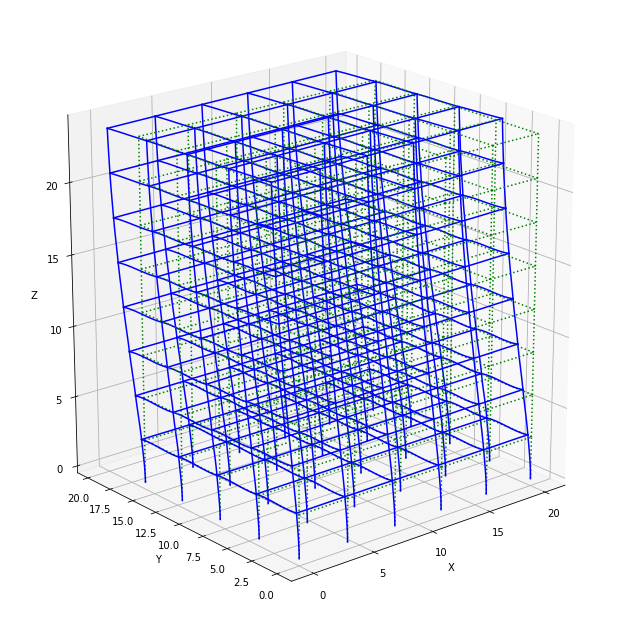

In [29]:
opsv.plot_defo(200,fig_wi_he=(30., 25.),az_el=(-130,20))


# Masas Efectivas

In [30]:
Tags = getNodeTags()
# print(Tags)
modo = np.zeros((Nmodes,3*nz))
for j in range(1,Nmodes+1):
    ind = 0
    for i in Tags[-nz:]:
        temp = nodeEigenvector(i,j)
        modo[j-1,[ind,ind+1,ind+2]] = temp[0],temp[1],temp[-1]
        ind = ind + 3

# Definimos valores iniciales
Ux,Uy,Rz = np.zeros(3*nz),np.zeros(3*nz),np.zeros(3*nz)
Ux[0::3]=1
Uy[1::3]=1
Rz[2::3]=1
SUMx, SUMy, SUMr = 0., 0., 0.
ni = 0

Mx = sum(sum(MF[0::3,0::3]))
My = sum(sum(MF[1::3,1::3]))
Mr = sum(sum(MF[2::3,2::3]))

df3 = pd.DataFrame(columns=['Modo','T(s)','SumUx','SumUy','SumRz'])
for j in range(1,Nmodes+1):
    FPx = modo[j-1].T@MF@Ux
    FPy = modo[j-1].T@MF@Uy
    FPr = modo[j-1].T@MF@Rz
    FPRx = FPx**2/Mx
    FPRy = FPy**2/My
    FPRr = FPr**2/Mr
    SUMx = SUMx + FPRx
    SUMy = SUMy + FPRy
    SUMr = SUMr + FPRr
    #
    if min(SUMx,SUMy,SUMr)>=0.90 and ni==0:
        ni = j
    df3 = df3.append({'Modo':j, 'T(s)':Tmodes[j-1],'SumUx':SUMx,
                    'SumUy':SUMy,'SumRz':SUMr}, ignore_index=True)
print(df3.round(5))
print('N° mínimo de Modos a considerar:',ni)

    Modo     T(s)    SumUx    SumUy    SumRz
0    1.0  0.72187  0.00000  0.80667  0.00000
1    2.0  0.70772  0.80887  0.80667  0.00000
2    3.0  0.63466  0.80887  0.80667  0.81305
3    4.0  0.23109  0.80887  0.91035  0.81305
4    5.0  0.22713  0.91118  0.91035  0.81305
5    6.0  0.20445  0.91118  0.91035  0.91182
6    7.0  0.12877  0.91118  0.94986  0.91182
7    8.0  0.12717  0.95043  0.94986  0.91182
8    9.0  0.11550  0.95043  0.94986  0.95076
9   10.0  0.08541  0.95043  0.97190  0.95076
10  11.0  0.08459  0.97227  0.97190  0.95076
11  12.0  0.07700  0.97227  0.97190  0.97239
N° mínimo de Modos a considerar: 6


# Análisis Dinámico Modal Espectral

In [31]:
#@title
def getCombo(E030,MF,modo,Tmodes,NT,ni):

    # Definimos valores iniciales
    D_ABSx,D_RCSCx = np.zeros(NT),np.zeros(NT)
    Δ_ABSx,Δ_RCSCx = np.zeros(NT),np.zeros(NT)
    V_ABSx,V_RCSCx = np.zeros(NT),np.zeros(NT)
    D_ABSy,D_RCSCy = np.zeros(NT),np.zeros(NT)
    Δ_ABSy,Δ_RCSCy = np.zeros(NT),np.zeros(NT)
    V_ABSy,V_RCSCy = np.zeros(NT),np.zeros(NT)

    # Se realiza la Superpocisión Modal Espectral
    for j in range(1,ni+1):#ni+1
        FPx=modo[j-1].T@MF@Ux
        FPy=modo[j-1].T@MF@Uy
        FPr=modo[j-1].T@MF@Rz
        #
        Sa = E030[j-1]*9.80665
        Sd = Sa/(2*np.pi/Tmodes[j-1])**2
        #
        respDX = Sd*FPx*modo[j-1]
        respAX = Sa*FPx*MF@modo[j-1]
        D_ABSx = D_ABSx + abs(respDX)
        D_RCSCx = D_RCSCx + (respDX)**2
        respDX[3:] = respDX[3:] - respDX[:-3]
        Δ_ABSx = Δ_ABSx + abs(respDX)
        Δ_RCSCx = Δ_RCSCx + (respDX)**2
        V_ABSx = V_ABSx + abs(np.cumsum(respAX[::-1])[::-1])
        V_RCSCx = V_RCSCx + (np.cumsum(respAX[::-1])[::-1])**2
        #
        respDY = Sd*FPy*modo[j-1]
        respAY = Sa*FPy*MF@modo[j-1]
        D_ABSy = D_ABSy + abs(respDY)
        D_RCSCy = D_RCSCy + (respDY)**2
        respDY[3:] = respDY[3:] - respDY[:-3]
        Δ_ABSy = Δ_ABSy + abs(respDY)
        Δ_RCSCy = Δ_RCSCy + (respDY)**2
        V_ABSy = V_ABSy + abs(np.cumsum(respAY[::-1])[::-1])
        V_RCSCy = V_RCSCy + (np.cumsum(respAY[::-1])[::-1])**2

    # Se realiza la combinación 25%ABS + 75%RCSC
    D_RCSCx = D_RCSCx**0.5
    Δ_RCSCx = Δ_RCSCx**0.5
    V_RCSCx = V_RCSCx**0.5
    DDx = 0.25*D_ABSx + 0.75*D_RCSCx
    ΔDx = 0.25*Δ_ABSx + 0.75*Δ_RCSCx
    VDx = 0.25*V_ABSx + 0.75*V_RCSCx
    #
    D_RCSCy = D_RCSCy**0.5
    Δ_RCSCy = Δ_RCSCy**0.5
    V_RCSCy = V_RCSCy**0.5
    DDy = 0.25*D_ABSy + 0.75*D_RCSCy
    ΔDy = 0.25*Δ_ABSy + 0.75*Δ_RCSCy
    VDy = 0.25*V_ABSy + 0.75*V_RCSCy
    
    df = pd.DataFrame(columns=['Nivel','VDx(kN)','VDy(kN)','UDx(cm)','UDy(cm)'])
    for i in range(int(NT/3)):
        df = df.append({'Nivel':i+1, 'VDx(kN)':VDx[0::3][i]/1000,
        'VDy(kN)':VDy[1::3][i]/1000,'UDx(cm)':DDx[0::3][i]*100,
        'UDy(cm)':DDy[1::3][i]*100}, ignore_index=True)

    return DDx, ΔDx, VDx, DDy, ΔDy, VDy, df

In [32]:
DDx, ΔDx, VDx, DDy, ΔDy, VDy, df4 = getCombo(E030,MF,modo,Tmodes,3*nz,ni)
print('\nANÁLISIS DINÁMICO SIN ESCALAR')
df4 = df4.astype({'Nivel':int})
print(df4.round(4))


ANÁLISIS DINÁMICO SIN ESCALAR
   Nivel    VDx(kN)    VDy(kN)  UDx(cm)  UDy(cm)
0      1  1916.1721  1879.4193   0.1438   0.1443
1      2  1848.7592  1813.1350   0.3769   0.3806
2      3  1687.6920  1654.3178   0.6078   0.6157
3      4  1497.3543  1465.6831   0.8124   0.8248
4      5  1341.0577  1315.7047   0.9822   0.9988
5      6  1121.2429  1103.5497   1.1177   1.1383
6      7   813.1925   803.1272   1.2312   1.2567
7      8   413.9616   410.2220   1.3000   1.3299


In [33]:
# Escalamiento de los resultados del análisis dinámico
if VDx[0::3][0]<0.80*VS[0]:
    FSx  = 0.80*VS[0]/VDx[0::3][0]
    msjx = 'SI es necesario aplicar un Factor de Escala en X: %.4f'%FSx
else:
    FSx = 1.
    msjx = 'NO es necesario escalar en X'

if VDy[0::3][0]<0.80*VS[0]:
    FSy  = 0.80*VS[0]/VDy[0::3][0]
    msjy = 'SI es necesario aplicar un Factor de Escala en Y: %.4f'%FSy
else:
    FSy = 1.
    msjy = 'NO es necesario escalar en Y'

texto1 = '\nAl comparar la cortante basal obtenida en el análisis dinámico en X \n\
(%.2f kN) y el 80%% de la cortante basal del análisis estático en X (%.2f kN), \n\
se obtiene que %s. '%(VDx[0::3][0]/1000,0.80*VS[0]/1000,msjx)
texto1 = texto1 + '\nEn la dirección Y, la cortante basal obtenida en el análisis \n\
dinámico es %.2f kN y el 80%% de la cortante basal del análisis estático es %.2f kN. \n\
Por lo que %s.'%(VDy[0::3][0]/1000,0.80*VS[0]/1000,msjy)
print(texto1)


Al comparar la cortante basal obtenida en el análisis dinámico en X 
(1916.17 kN) y el 80% de la cortante basal del análisis estático en X (1729.18 kN), 
se obtiene que NO es necesario escalar en X. 
En la dirección Y, la cortante basal obtenida en el análisis 
dinámico es 1879.42 kN y el 80% de la cortante basal del análisis estático es 1729.18 kN. 
Por lo que NO es necesario escalar en Y.


In [34]:
# Se aplican los Factores de Escala
print('\nANÁLISIS DINÁMICO FINAL')
df5 = pd.DataFrame(columns=['Nivel','Vx(kN)','Vy(kN)','Ux(cm)','Uy(cm)','Δx(‰)','Δy(‰)'])
for i in range(nz):
    Δx = 0.75*Ro*ΔDx[0::3][i]/dz
    Δy = 0.75*Ro*ΔDy[1::3][i]/dz
    #
    df5 = df5.append({'Nivel':i+1, 'Vx(kN)':FSx*VDx[0::3][i]/1000,
        'Vy(kN)':FSy*VDy[1::3][i]/1000,'Ux(cm)':0.75*Ro*DDx[0::3][i]*100,
        'Uy(cm)':0.75*Ro*DDy[1::3][i]*100,'Δx(‰)':Δx*1000,'Δy(‰)':Δy*1000}, ignore_index=True)
df5 = df5.astype({'Nivel':int})
print(df5.round(4))


ANÁLISIS DINÁMICO FINAL
   Nivel     Vx(kN)     Vy(kN)  Ux(cm)  Uy(cm)   Δx(‰)   Δy(‰)
0      1  1916.1721  1879.4193  0.8626  0.8658  2.8752  2.8861
1      2  1848.7592  1813.1350  2.2613  2.2834  4.6633  4.7264
2      3  1687.6920  1654.3178  3.6466  3.6943  4.6280  4.7135
3      4  1497.3543  1465.6831  4.8744  4.9486  4.2227  4.3142
4      5  1341.0577  1315.7047  5.8930  5.9930  3.8078  3.9095
5      6  1121.2429  1103.5497  6.7063  6.8298  3.2060  3.3121
6      7   813.1925   803.1272  7.3875  7.5400  2.3900  2.4925
7      8   413.9616   410.2220  7.7997  7.9792  1.4529  1.5470


<IPython.core.display.Javascript object>

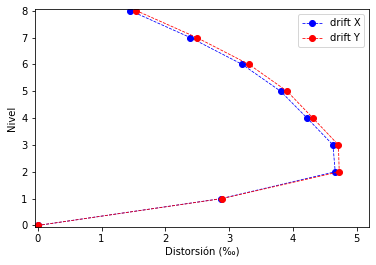

In [35]:
# Ploteamos las Distorsiones
vecX = np.array(df5.loc[:,'Δx(‰)'])
vecY = np.array(df5.loc[:,'Δy(‰)'])
lim = 1.1*max(vecX.max(),vecY.max())
#
plt.plot(np.insert(vecX,0,0),np.arange(nz+1),'bo--',label='drift X',lw = 0.8)
plt.plot(np.insert(vecY,0,0),np.arange(nz+1),'ro--',label='drift Y',lw = 0.8)
plt.legend()
plt.xlabel('Distorsión (‰)')
plt.ylabel('Nivel')
plt.axis([-0.05,lim,-0.05,nz+0.05])
plt.yticks(np.arange(0, nz+0.05, 1))
plt.savefig('./distorsion_din.png')